In [37]:
from pathlib import Path

from PIL import Image

import pandas as pd
import torch as pt
import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch, Rectangle

from importables.pytorch.dataset import SegmentationDataset
from importables.project.cloud_classes import ClassRegistry

### User Input

In [38]:
SEED = 1234
SUBSET_RATIO = 0.1

MODELS = [
    # ('satlas', 'feature_extraction_botched', 'SatlasNet - Feature Extraction'),
    # ('lsknet', 'feature_extraction', 'LSKNet - Feature Extraction'),
    ('samhq', pts:=1, f'SamHQ - {pts*2} Sample Point'),
    ('samhq', pts:=10, f'SamHQ - {pts*2} Sample Point'),
    ('samhq', pts:=100, f'SamHQ - {pts*2} Sample Point'),
    ('samhq', pts:=1000, f'SamHQ - {pts*2} Sample Point'),
    # ('samhq', pts:=1, f'SamHQ - {pts*2} Sample Point')
    # ('satlas', 'stages_frozen_3', 'SatlasNet - 3 Stages Frozen'),
]
CHIPS = [
    'LC81820302014180LGN00_26_27',
    'LC81770262013254LGN00_27_7',
    'LC81001082014022LGN00_36_24',
    'LC81640502013179LGN01_20_25'
]

FMASK_FLAG = False

### Paths

In [39]:
PROJ_PATH = Path('../')

DATA_PATH = PROJ_PATH / '_data'
DATASET_PATH = DATA_PATH / 'dataset'

PLOTS_PATH = PROJ_PATH / "plots"
PLOTS_PATH.mkdir(exist_ok=True)

df = pd.read_csv(DATA_PATH / f'seeds/{SEED}_{SUBSET_RATIO}_split.csv', index_col=0)

In [40]:
import sys

pkg_root = PROJ_PATH / 'models' / 'samhq'
sys.path.insert(0, str(pkg_root))

from models.samhq.main import SAM_predictor, SAM_predict

### Metadata

In [41]:
sub_df = df[df['split'] == 'test']

# sub_df = sub_df[sub_df['biome'] == 'Snow/Ice']

sub_df = sub_df[sub_df['clear'] >= 0.01]
sub_df = sub_df[sub_df['cloud'] >= 0.01]
sub_df = sub_df[sub_df['thin_cloud'] >= 0.01]
sub_df = sub_df[sub_df['shadow'] >= 0.01]

In [42]:
sub_df

,image_path,split,image_name,subset,clear,cloud,thin_cloud,shadow,biome
54301,_data/dataset/img/LC80010732013109LGN00_9_23.png,test,LC80010732013109LGN00_9_23.png,False,0.817622,0.096082,0.031051,0.055246,Shrubland
54315,_data/dataset/img/LC81640502013179LGN01_20_25.png,test,LC81640502013179LGN01_20_25.png,False,0.078544,0.613381,0.197923,0.110152,Barren
54344,_data/dataset/img/LC81930452013126LGN01_25_21.png,test,LC81930452013126LGN01_25_21.png,True,0.204600,0.524434,0.245217,0.025749,Barren
54366,_data/dataset/img/LC80160502014041LGN00_27_25.png,test,LC80160502014041LGN00_27_25.png,False,0.267538,0.319316,0.155473,0.257673,Forest
54400,_data/dataset/img/LC81770262013254LGN00_28_23.png,test,LC81770262013254LGN00_28_23.png,True,0.905513,0.024932,0.012038,0.057518,Urban
...,...,...,...,...,...,...,...,...,...
72318,_data/dataset/img/LC81930452013126LGN01_12_16.png,test,LC81930452013126LGN01_12_16.png,True,0.346520,0.232282,0.178512,0.242686,Barren
72322,_data/dataset/img/LC81770262013254LGN00_4_28.png,test,LC81770262013254LGN00_4_28.png,False,0.778898,0.032605,0.077627,0.110870,Urban
72347,_data/dataset/img/LC81310182013108LGN01_8_2.png,test,LC81310182013108LGN01_8_2.png,False,0.071090,0.183315,0.639987,0.105608,Forest
72349,_data/dataset/img/LC81620432014072LGN00_13_26.png,test,LC81620432014072LGN00_13_26.png,False,0.934192,0.016661,0.031768,0.017379,Urban


### Plotting

In [ ]:
class_reg = ClassRegistry()

LEGEND_ELEMENTS = [
    Patch(facecolor=class_reg.CLASS_HEX_COLORS[0], edgecolor='black', label='Clear'),
    Patch(facecolor=class_reg.CLASS_HEX_COLORS[1], edgecolor='black', label='Cloud'),
    Patch(facecolor=class_reg.CLASS_HEX_COLORS[2], edgecolor='black', label='Thin Cloud'),
    Patch(facecolor=class_reg.CLASS_HEX_COLORS[3], edgecolor='black', label='Cloud Shadow')
]

def gamma_correct(img: np.ndarray, gamma: float = 0.9) -> np.ndarray:
    img = img.astype(np.float32) / 255.0
    corrected = np.power(img, gamma)
    
    return np.clip(corrected * 255, 0, 255).astype(np.uint8)

def set_image(img: NDArray, idx: int, title: str, gs: GridSpec, fig):
    ax = fig.add_subplot(gs[idx])
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                     fill=False, edgecolor='black',
                     linewidth=2, zorder=1000)
    ax.add_patch(rect)

def plot_predictions(img: NDArray, preds: list[NDArray], mask: NDArray, fmask: NDArray,
                     subtitles: list[str], suptitle: str):
    IMAGE_COUNT = len(preds) + 3
    if not FMASK_FLAG: IMAGE_COUNT -= 1
    
    # Reserve extra space for legend
    gs = GridSpec(1, IMAGE_COUNT + 1, wspace=0.1, width_ratios=[1]*IMAGE_COUNT + [0.3])
    fig = plt.figure(figsize=((scale:=4) * (IMAGE_COUNT + 0.5), scale))
    fig.suptitle(suptitle, y=1.02)

    # Original image
    set_image(img, 0, 'Image', gs, fig)
    
    # FMask 3.3
    if FMASK_FLAG:
        set_image(fmask, 1, 'FMask 3.3', gs, fig)

    # Predictions
    for idx in range(len(preds)):
        set_image(preds[idx], idx + (2 if FMASK_FLAG else 1), subtitles[idx], gs, fig)

    # Ground truth
    set_image(mask, IMAGE_COUNT - 1, "Ground truth", gs, fig)

    # Legend
    legend_ax = fig.add_subplot(gs[-1])
    legend_ax.axis('off')
    legend_ax.legend(handles=LEGEND_ELEMENTS, loc='center left', frameon=False)

    plt.show()
    fig.savefig(PLOTS_PATH / f"{suptitle}.png", dpi=600, bbox_inches="tight")
    plt.close(fig)

### Predictions

In [47]:
seg_ds = SegmentationDataset(SEED, 'test', DATA_PATH.absolute(), subset_ratio=SUBSET_RATIO)
transform = seg_ds.img_transform

predictor, rng = SAM_predictor(PROJ_PATH / 'models' / 'samhq' / 'sam_hq_vit_b.pth', SEED)

def get_datapoint(name: str) -> tuple[NDArray, pt.Tensor, NDArray, NDArray]:
    img_path = DATASET_PATH / "img" / f"{name}.png"
    mask_path = DATASET_PATH  / "label" / f"{name}.png"
    fmask_path = DATASET_PATH / 'fmask' / f"{name}.png"
    
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to("cuda")
    
    mask = np.array(Image.open(mask_path))
    fmask = np.array(Image.open(fmask_path))
    
    return np.array(img), img_tensor, mask, fmask

def run_SAM_prediction(img_arr: NDArray, lbl_arr: NDArray, num_points: int):
    pred = SAM_predict(img_arr, lbl_arr, num_points, predictor, rng)
    pred = class_reg.class_recolor_map(pred)
    
    return pred

def run_prediction(img_tensor: pt.Tensor, model_name: str, ver: str | int) -> NDArray:
    model_path = PROJ_PATH / "models" / model_name / "logs" / f"seed-{SEED}" / ver / "model.pt"
        
    model: pt.nn.Module = pt.jit.load(model_path).to("cuda")
    model.eval()
        
    with pt.no_grad():
        pred = model(img_tensor).argmax(axis=1).squeeze(axis=0).cpu()
        pred = pred.numpy().astype(np.uint8)
        pred = class_reg.class_recolor_map(pred)
        
    return pred

Seed set to 1234


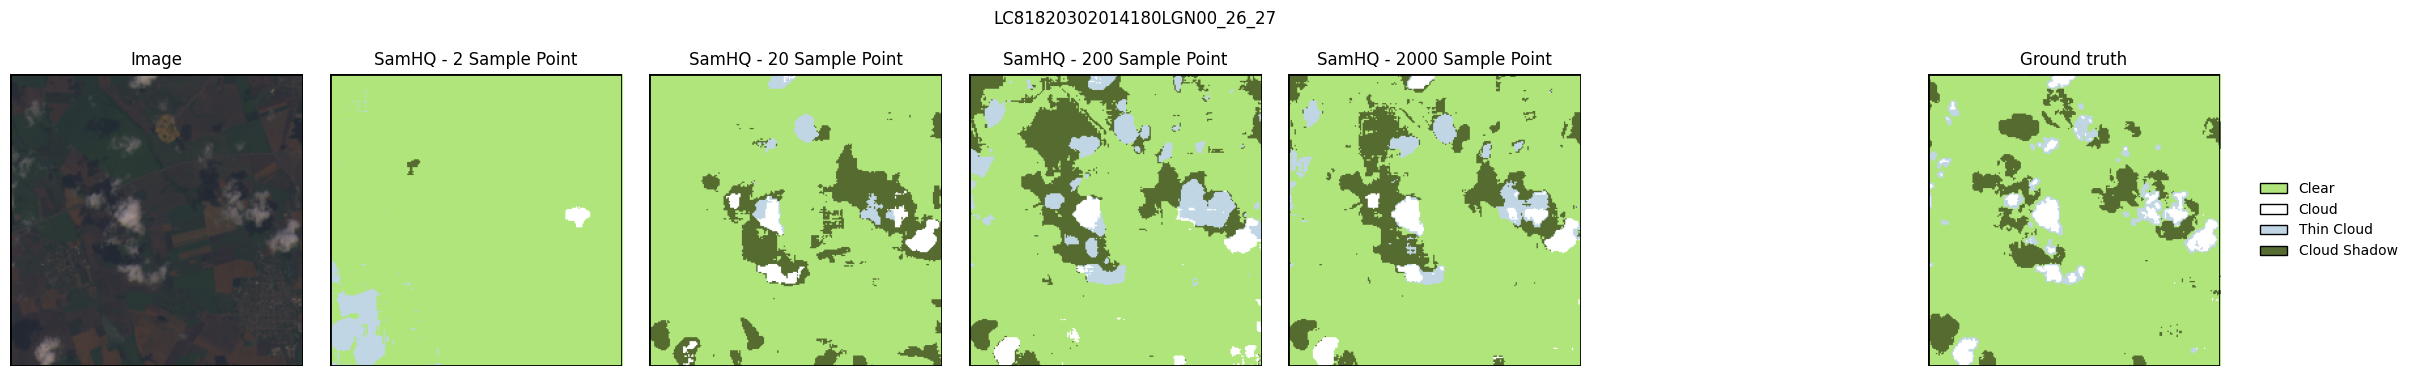

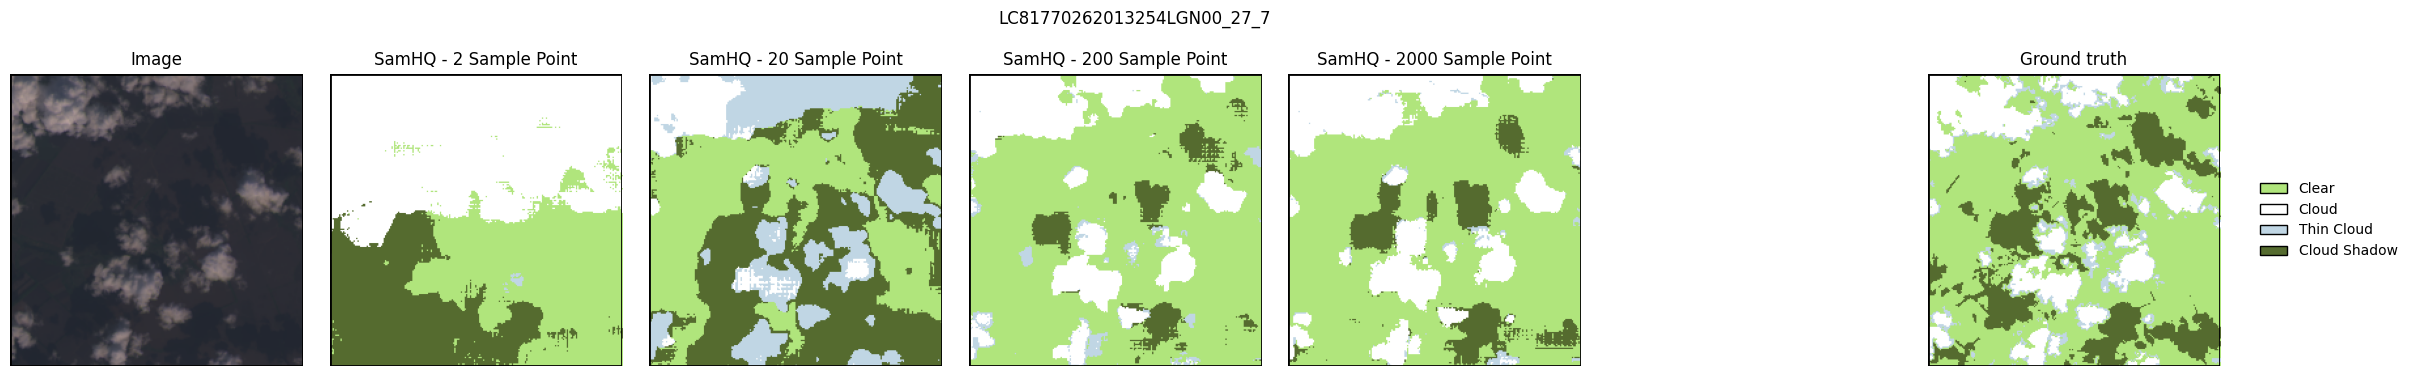

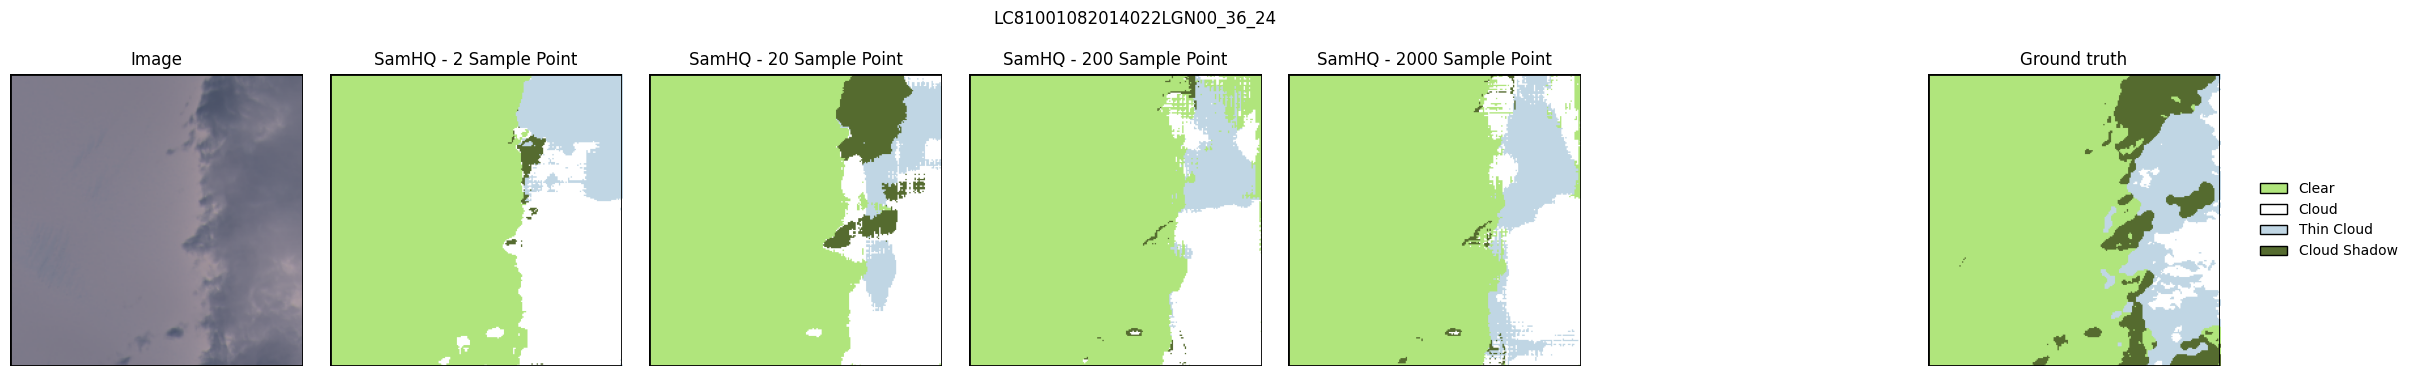

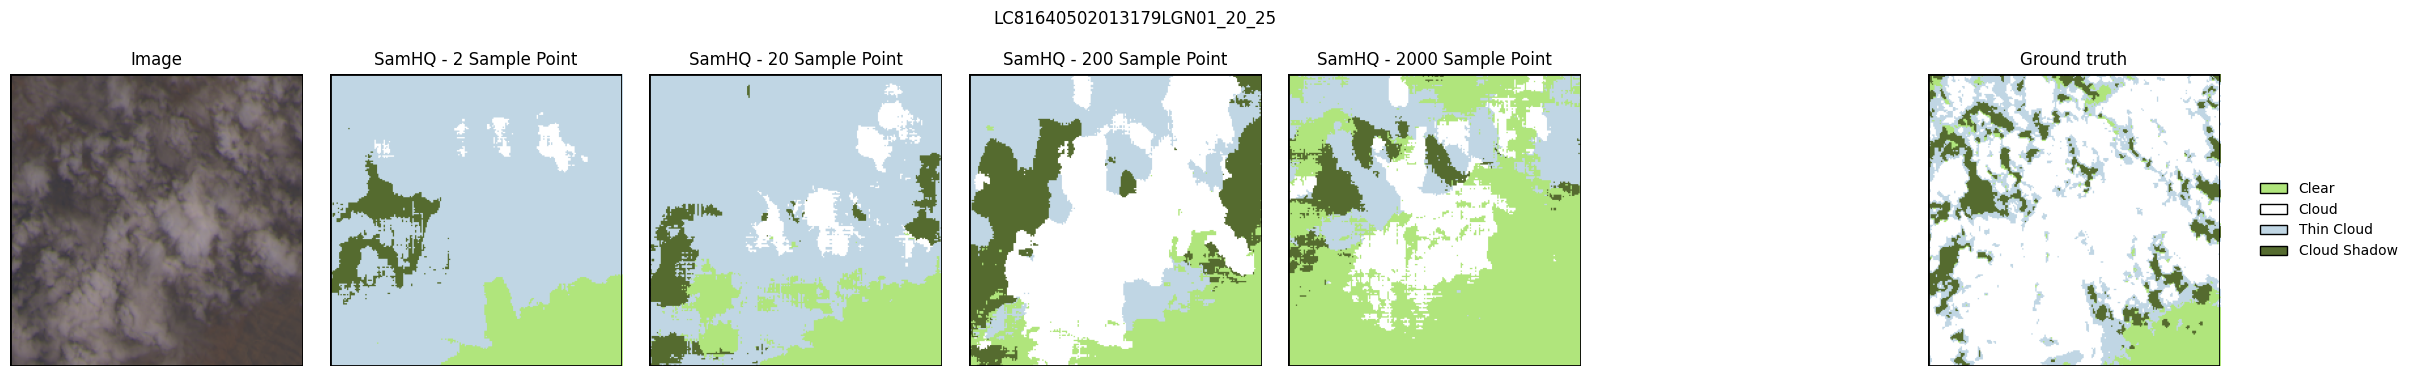

In [48]:
for chip in CHIPS:
    img_arr, img_tensor, mask, fmask = get_datapoint(chip)
    
    preds = []
    subtitles = []
    
    for model_name, ver, subtitle in MODELS:
        match model_name:
            case 'samhq':
                pred = run_SAM_prediction(img_arr, mask, ver)
                
            case _:
                pred = run_prediction(img_tensor, model_name, ver)
                
        preds.append(pred)
        subtitles.append(subtitle)
        
    mask = class_reg.class_recolor_map(mask)
    fmask = class_reg.class_recolor_map(fmask)
        
    plot_predictions(img_arr, preds, mask, fmask, subtitles, chip)